## Predict housing prices from data patterns
in a *Kaggle* database with information from houses in Ames, Iowa containing:
* 80 descriptive variables
    * 37 numerical variables
    * 43 categorical variables
    
**Objective:** reduce prediction errors as much as possible using **XGBoost** models (Gradient Boosted Decision Trees)

**Author:** Leonardo Espin.

Licensing: This code is distributed under the Mozilla Public License Version 2.0. Date: 09/28/2018

In [2]:
# Loading libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

## Data preparation
1. Load data

In [4]:
#Dataset file has to be downloaded from Kaggle after creating an account
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Train: ' + str(train.shape) +' | Test: '+str(test.shape))
print('Training data fields: {}, total numerical fields: {}'
      .format(len(train.columns)-1,len(train.describe().columns)-1))
train.head()#shows the first few rows

Train: (1460, 81) | Test: (1459, 80)
Training data fields: 80, total numerical fields: 37


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


2. Comparing variables in train and test datasets

In [5]:
trainVars=set(train.columns)
testVars=set(test.columns)
print("\'SalePrice\' is the target variable ({} missing values)"
      .format(train.loc[:,'SalePrice'].isna().sum()))
print("Columns in train set and not in test :", trainVars-testVars) 
print("Columns in test set and not in train :", testVars-trainVars) 

'SalePrice' is the target variable (0 missing values)
Columns in train set and not in test : {'SalePrice'}
Columns in test set and not in train : set()


3. Combine train and test data into single data frame for preparation purposes

In [6]:
train['source']= 'train' #adding a source column first
test['source'] = 'test'
cols1=train.columns
test['SalePrice']=np.nan
data=pd.concat([train, test],ignore_index=True,sort=False)
cols2=data.columns
data.drop(['Id'],axis=1,inplace=True)
print('Entire dataset : ' + str(data.shape)+'\n')
print(cols2==cols1) #check that original variable order has been preserved

Entire dataset : (2919, 81)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]


4. Check missing data:

In [5]:
tmp=data.isna().sum()
tmp=tmp.loc[tmp >0] #variables with missing values
tmp.drop(index='SalePrice',inplace=True)

#concatenate number of missing values with variable type
dfA=pd.DataFrame(tmp,columns=['Missing'])
#dfB=pd.DataFrame(data.loc[:,list(tmp.index.values)].dtypes,columns=['Type'])
dfB=pd.DataFrame(data.loc[:,tmp.index].dtypes,columns=['Type'])
dfMissing=pd.concat([dfA,dfB],axis=1).sort_values('Missing',ascending=False)
dfMissing

,Missing,Type
PoolQC,2909,object
MiscFeature,2814,object
Alley,2721,object
Fence,2348,object
FireplaceQu,1420,object
LotFrontage,486,float64
GarageFinish,159,object
GarageQual,159,object
GarageCond,159,object
GarageYrBlt,159,float64


5. Group variables with missing data by type and amount of missing data

In [6]:
#Make list with variables with few missing rows (< 5 rows)
#these numerical variables will be imputed
fewNumMissing=list(dfA.loc[(dfA.loc[:,'Missing']<5) 
                           & (dfB.loc[:,'Type']=='float64')].index.values)#no int types above
#these variables have to be analyzed individually
fewCatMissing=list(dfA.loc[(dfA.loc[:,'Missing']<5) 
                           & (dfB.loc[:,'Type']=='object')].index.values)

#Make list with variables with too many missing rows (> 500 rows)
#these variables will be replaced with a binary variable which says if value is missing or not
manyCatMissing=list(dfMissing.loc[dfMissing.loc[:,'Missing']>500].index.values)

#Add LotFrontage,GarageYrBlt,MasVnrArea to numerical variables to be imputed
fewNumMissing=fewNumMissing +['LotFrontage','GarageYrBlt','MasVnrArea']

#Make list of remaining variables with missing data
otherMissing=list(set(dfMissing.index.values)
                  -set(fewNumMissing+fewCatMissing+manyCatMissing))
dfMissing.loc[otherMissing]

,Missing,Type
GarageCond,159,object
MasVnrType,24,object
BsmtCond,82,object
BsmtFinType1,79,object
GarageType,157,object
GarageFinish,159,object
GarageQual,159,object
BsmtFinType2,80,object
BsmtExposure,82,object
BsmtQual,81,object


6. Impute numerical variables with missing data

In [7]:
#check statistics of variables
for var in fewNumMissing: 
    print('________')
    print(data[var].describe())

________
count    2918.000000
mean      441.423235
std       455.610826
min         0.000000
25%         0.000000
50%       368.500000
75%       733.000000
max      5644.000000
Name: BsmtFinSF1, dtype: float64
________
count    2918.000000
mean       49.582248
std       169.205611
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1526.000000
Name: BsmtFinSF2, dtype: float64
________
count    2918.000000
mean      560.772104
std       439.543659
min         0.000000
25%       220.000000
50%       467.000000
75%       805.500000
max      2336.000000
Name: BsmtUnfSF, dtype: float64
________
count    2918.000000
mean     1051.777587
std       440.766258
min         0.000000
25%       793.000000
50%       989.500000
75%      1302.000000
max      6110.000000
Name: TotalBsmtSF, dtype: float64
________
count    2917.000000
mean        0.429894
std         0.524736
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max 

In [8]:
for var in fewNumMissing:
    val=data[var].median()
    print('Filling \''+var+'\' with {}'.format(val) )
    data[var].fillna(data[var].median(),inplace=True)

Filling 'BsmtFinSF1' with 368.5
Filling 'BsmtFinSF2' with 0.0
Filling 'BsmtUnfSF' with 467.0
Filling 'TotalBsmtSF' with 989.5
Filling 'BsmtFullBath' with 0.0
Filling 'BsmtHalfBath' with 0.0
Filling 'GarageCars' with 2.0
Filling 'GarageArea' with 480.0
Filling 'LotFrontage' with 68.0
Filling 'GarageYrBlt' with 1979.0
Filling 'MasVnrArea' with 0.0


7. List categories of all categorical variables (with/without missing data)

In [9]:
for var in data.columns: 
    if data[var].dtype == 'O': #and object data type
        print('________')
        if var in fewCatMissing:
            print('Variable has few data points missing')
        elif var in otherMissing:
            print('Variable as several data points missing')
        elif var in manyCatMissing:
            print('Variable is mostly missing')
        else:
            print('This is a complete variable')
        print(pd.concat([data[var].value_counts(),#counts by category
           train[[var,'SalePrice']].groupby(var).mean()],#price average by category
          axis=1,sort=True).sort_values(var,ascending=False))

________
Variable has few data points missing
         MSZoning      SalePrice
RL           2265  191004.994787
RM            460  126316.830275
FV            139  214014.061538
RH             26  131558.375000
C (all)        25   74528.000000
________
This is a complete variable
      Street      SalePrice
Pave    2907  181130.538514
Grvl      12  130190.500000
________
Variable is mostly missing
       Alley      SalePrice
Alley                      
Grvl     120  122219.080000
Pave      78  168000.585366
________
This is a complete variable
     LotShape      SalePrice
Reg      1859  164754.818378
IR1       968  206101.665289
IR2        76  239833.365854
IR3        16  216036.500000
________
This is a complete variable
     LandContour      SalePrice
Lvl         2622  180183.746758
HLS          120  231533.940000
Bnk          117  143104.079365
Low           60  203661.111111
________
Variable has few data points missing
           Utilities     SalePrice
Utilities                  

/home/perro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 'Alley' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  
/home/perro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 'Utilities' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  
/home/perro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 'LandSlope' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


    ExterCond      SalePrice
TA       2538  184034.896256
Gd        299  168897.568493
Fa         67  102595.142857
Ex         12  201333.333333
Po          3   76500.000000
________
This is a complete variable
        Foundation      SalePrice
PConc         1308  225230.442040
CBlock        1235  149805.714511
BrkTil         311  132291.075342
Slab            49  107365.625000
Stone           11  165959.166667
Wood             5  185666.666667
________
Variable as several data points missing
    BsmtQual      SalePrice
TA      1283  140759.818182
Gd      1209  202688.478964
Ex       258  327041.041322
Fa        88  115692.028571
________
Variable as several data points missing
    BsmtCond      SalePrice
TA      2606  183632.620900
Gd       122  213599.907692
Fa       104  121809.533333
Po         5   64000.000000
________
Variable as several data points missing
    BsmtExposure      SalePrice
No          1904  165652.295908
Av           418  206643.420814
Gd           276  257689.805

8. For categoviral variables with large fraction of missing rows, create binary variables indicating if data point is missing or not

In [10]:
manyCatMissing.remove('FireplaceQu') #decided to keep categories for this variable
manyCatMissing

['PoolQC', 'MiscFeature', 'Alley', 'Fence']

In [11]:
for var in manyCatMissing: 
    data[var+'_missing']=data[var].apply(lambda x: 1 if pd.isnull(x) else 0)
    print(data[[var,var+'_missing']].head(10))
    data.drop(var,axis=1,inplace=True)

  PoolQC  PoolQC_missing
0    NaN               1
1    NaN               1
2    NaN               1
3    NaN               1
4    NaN               1
5    NaN               1
6    NaN               1
7    NaN               1
8    NaN               1
9    NaN               1
  MiscFeature  MiscFeature_missing
0         NaN                    1
1         NaN                    1
2         NaN                    1
3         NaN                    1
4         NaN                    1
5        Shed                    0
6         NaN                    1
7        Shed                    0
8         NaN                    1
9         NaN                    1
  Alley  Alley_missing
0   NaN              1
1   NaN              1
2   NaN              1
3   NaN              1
4   NaN              1
5   NaN              1
6   NaN              1
7   NaN              1
8   NaN              1
9   NaN              1
   Fence  Fence_missing
0    NaN              1
1    NaN              1
2    NaN       

In [12]:
var='FireplaceQu'
data[var].fillna('missing',inplace=True)
data[var].value_counts()

missing    1420
Gd          744
TA          592
Fa           74
Po           46
Ex           43
Name: FireplaceQu, dtype: int64

9. Handle individual categorical variables:
  * `MSZoning`: is important, will keep categories and add missing since few missing

In [13]:
var='MSZoning'
data[var].fillna('missing',inplace=True)
data[var].value_counts()

RL         2265
RM          460
FV          139
RH           26
C (all)      25
missing       4
Name: MSZoning, dtype: int64

  * `Street`: make 'Pave' 1 else 0

In [14]:
var='Street'
data[var] = data[var].apply(lambda x: 1 if x == 'Pave' else 0)
data[var].value_counts()

1    2907
0      12
Name: Street, dtype: int64

  * `LotShape`: group IR2, IR3 and IR1, make binary, Reg = 1

In [15]:
var='LotShape'
data[var] = data[var].apply(lambda x: 1 if x == 'Reg' else 0)
data[var].value_counts()

1    1859
0    1060
Name: LotShape, dtype: int64

  * Variables whose categories will be kept, and a 'missing' category created if thera are missing rows. In all these cases keeping the categories adds information to the model:

`LandContour`(**debatable**),`LotConfig`,`Neighborhood`,`Condition1`,`Exterior1st`,`Exterior2nd`,
`MasVnrType`,`ExterQual`,`ExterCond`,`Foundation`,`BsmtQual`,`BsmtCond`,`BsmtExposure`,
`BsmtFinType1`,`HeatingQC`,`Electrical`,`KitchenQual`,`GarageType`,`GarageFinish`,
`GarageQual`,`SaleType`,`SaleCondition`

In [16]:
keep=['LandContour','LotConfig','Neighborhood','Condition1','Exterior1st','Exterior2nd',
'MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure',
'BsmtFinType1','HeatingQC','Electrical','KitchenQual','GarageType','GarageFinish',
'GarageQual','SaleType','SaleCondition']
for var in keep:
    data[var].fillna('missing',inplace=True)
    print(data[var].value_counts())

Lvl    2622
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64
Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Name: Neighborhood, dtype: int64
Norm      2511
Feedr      164
Artery      92
RRAn        50
PosN        39
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: Condition1, dtype: int64
VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
Stone         2
CBlock        2
AsphShn       2
missing     

  * `Utilities`: leave category 'AllPub' as is, group all others in category 'other' and make variable binary

In [17]:
var='Utilities'
data[var] = data[var].apply(lambda x: 1 if x == 'AllPub' else 0)
data[var].value_counts()

1    2916
0       3
Name: Utilities, dtype: int64

  * `LandSlope`: leave category 'Gtl' as is group others as 'others' and make variable binary

In [18]:
var='LandSlope'
data[var] = data[var].apply(lambda x: 1 if x == 'Gtl' else 0)
data[var].value_counts()

1    2778
0     141
Name: LandSlope, dtype: int64

  * `Condition2`: most are Norm, with average price, too few remaining. Drop it

In [19]:
var='Condition2'
data.drop([var],axis=1,inplace=True)

  * `BldgType`: group 1Fam, TwnhsE and other group for remaining categories Duplex, Twnhs, 2fmCon, make binary

In [20]:
var='BldgType'
data[var] = data[var].apply(lambda x: 1 if x in ['1Fam','TwnhsE'] else 0)
data[var].value_counts()

1    2652
0     267
Name: BldgType, dtype: int64

  * `HouseStyle`: leave categories '1Story' and '2Story' as they are and group others

In [21]:
var='HouseStyle'
data[var] = data[var].apply(lambda x: 'others' if x not in ['1Story','2Story'] else x)
data[var].value_counts()

1Story    1471
2Story     872
others     576
Name: HouseStyle, dtype: int64

  * `RoofStyle`: keep 'Gable', 'Hip', and group others

In [22]:
var='RoofStyle'
data[var] = data[var].apply(lambda x: x if x in ['Gable','Hip'] else 'others')
data[var].value_counts()

Gable     2310
Hip        551
others      58
Name: RoofStyle, dtype: int64

  * `RoofMatl`: most in one categorie, too few others. Drop it

In [23]:
var='RoofMatl'
data.drop([var],axis=1,inplace=True)

  * `BsmtFinType2`: make Unf 1, others 0

In [24]:
var='BsmtFinType2'
data[var] = data[var].apply(lambda x: 1 if x == 'Unf' else 0)
data[var].value_counts()

1    2493
0     426
Name: BsmtFinType2, dtype: int64

  * `Heating`: make GasA 1, others 0

In [25]:
var='Heating'
data[var] = data[var].apply(lambda x: 1 if x == 'GasA' else 0)
data[var].value_counts()

1    2874
0      45
Name: Heating, dtype: int64

  * `CentralAir`: make binary Y to 1, N to 0

In [26]:
var='CentralAir'
data[var] = data[var].apply(lambda x: 1 if x == 'Y' else 0)
data[var].value_counts()

1    2723
0     196
Name: CentralAir, dtype: int64

  * `Functional`: keep Typ, group others

In [27]:
var='Functional'
data[var] = data[var].apply(lambda x: 1 if x == 'Typ' else 0)
data[var].value_counts()

1    2717
0     202
Name: Functional, dtype: int64

  * `GarageCond`: keep TA, group others

In [28]:
var='GarageCond'
data[var] = data[var].apply(lambda x: 1 if x == 'TA' else 0)
data[var].value_counts()

1    2654
0     265
Name: GarageCond, dtype: int64

  * `PavedDrive`: Y to 1, others 0

In [29]:
var='PavedDrive'
data[var] = data[var].apply(lambda x: 1 if x == 'Y' else 0)
data[var].value_counts()

1    2641
0     278
Name: PavedDrive, dtype: int64

10. Check that dataset is complete (sale price is missing for test dataset, otherwise should be complete)

In [30]:
#all columns but SalePrice should have complete data
data.isna().sum().value_counts() 

0       78
1459     1
dtype: int64

11. One-hot encoding (**remove source variable before encoding**)

In [31]:
cat_vars = list(data.select_dtypes(['object']))
cat_vars.remove('source')
data = pd.get_dummies(data, columns=cat_vars)
data.head(10)

,MSSubClass,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,BldgType,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Functional,Fireplaces,GarageYrBlt,GarageCars,GarageArea,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,source,PoolQC_missing,...,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Electrical_missing,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,KitchenQual_missing,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,FireplaceQu_missing,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_missing,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_missing,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_missing,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_missing,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,1,1,1,1,1,7,5,2003,2003,196.0,706.0,1,0.0,150.0,856.0,1,1,856,854,0,1710,1.0,0.0,2,1,3,1,8,1,0,2003.0,2.0,548.0,1,1,0,61,0,0,0,0,0,2,2008,208500.0,train,1,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,20,80.0,9600,1,1,1,1,1,6,8,1976,1976,0.0,978.0,1,0.0,284.0,1262.0,1,1,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1,1976.0,2.0,460.0,1,1,298,0,0,0,0,0,0,5,2007,181500.0,train,1,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,60,68.0,11250,1,0,1,1,1,7,5,2001,2002,162.0,486.0,1,0.0,434.0,920.0,1,1,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,1,2001.0,2.0,608.0,1,1,0,42,0,0,0,0,0,9,2008,223500.0,train,1,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,70,60.0,9550,1,0,1,1,1,7,5,1915,1970,0.0,216.0,1,0.0,540.0,756.0,1,1,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1,1998.0,3.0,642.0,1,1,0,35,272,0,0,0,0,2,2006,140000.0,train,1,...,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
4,60,84.0,14260,1,0,1,1,1,8,5,2000,2000,350.0,655.0,1,0.0,490.0,1145.0,1,1,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,1,2000.0,3.0,836.0,1,1,192,84,0,0,0,0,0,12,2008,250000.0,train,1,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
5,50,85.0,14115,1,0,1,1,1,5,5,1993,1995,0.0,732.0,1,0.0,64.0,796.0,1,1,796,566,0,1362,1.0,0.0,1,1,1,1,5,1,0,1993.0,2.0,480.0,1,1,40,30,0,320,0,0,700,10,2009,143000.0,train,1,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
6,20,75.0,10084,1,1,1,1,1,8,5,2004,2005,186.0,1369.0,1,0.0,317.0,1686.0,1,1,1694,0,0,1694,1.0,0.0,2,0,3,1,7,1,1,2004.0,2.0,636.0,1,1,255,57,0,0,0,0,0,8,2007,307000.0,train,1,...,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
7,60,68.0,10382,1,0,1,1,1,7,6,1973,1973,240.0,859.0,0,32.0,216.0,1107.0,1,1,1107,983,0,2090,1.0,0.0,2,1,3,1,7,1,2,1973.0,2.0,484.0,1,1,235,204,228,0,0,0,350,11,2009,200000.0,train,1,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
8,50,51.0,6120,1,1,1,1,1,7,5,1931,1950,0.0,0.0,1,0.0,952.0,952.0,1,1,1022,752,0,1774,0.0,0.0,2,0,2,2,8,0,2,1931.0,2.0,468.0,1,1,90,0,205,0,0,0,0,4,2008,129900.0,train,1,...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
9,190,50.0,7420,1,1,1,1,0,5,6,1939,1950,0.0,851.0,1,0.0,140.0,991.0,1,1,1077,0,0,1077,1.0,0.0,1,0,2,2,5,1,2,1939.0,1.0,205.0,1,1,0,4,

In [32]:
#only the variable 'source' should remain categorical at this point
list(data.select_dtypes(['object']))

['source']

12. Separate train and test data and store in new files

In [33]:
train = data.loc[data['source']=='train'].copy() #copy is to make sure we're not chain-modifying data
test = data.loc[data['source']=='test'].copy()

In [34]:
train.drop('source',axis=1,inplace=True)
test.drop(['source','SalePrice'],axis=1,inplace=True)

/home/perro/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [35]:
train.to_csv('train_modified.csv',index=False)
test.to_csv('test_modified.csv',index=False)

### Load XGBoost and sklearn libraries

In [58]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn import metrics

In [ ]:
import matplotlib.pylab as plt
#set matplotlib options
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 4

  * Set target and predictor variables

In [39]:
target='SalePrice'
predictors =list(train.columns)
predictors.remove(target)

  * set a default regressor

In [42]:
xgb1 = XGBRegressor( #classifier because of binary targer variable
        learning_rate =0.1, #default value (high)
        n_estimators=1000,  #NOT default (100)
        max_depth=3,        #default (3)
        min_child_weight=1, #default
        gamma=0,            #default
        subsample=0.8,      #NOT default (1)
        colsample_bytree=0.8,#NOT default (1)
        nthread=4,
        scale_pos_weight=1, #default
        random_state=27)    #Random number seed

  * set parameters for sklearn cross validation and find **optimal number of estimators** for default `learning_rate` and default regressor

In [44]:
xgb_param = xgb1.get_xgb_params()
xgtrain = xgb.DMatrix(train[predictors].values,label=train[target].values)#data structure used by XGBoost
cvresult = xgb.cv(xgb_param, xgtrain, #performs cross validation
                  num_boost_round=xgb1.get_params()['n_estimators'],nfold=5,
                  metrics='mae', early_stopping_rounds=50)
xgb1.set_params(n_estimators=cvresult.shape[0])#sets 'n_estimators' from result of CV

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=336,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=27,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [45]:
#Fit the algorithm on the data
xgb1.fit(train[predictors], train[target],eval_metric='mae')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=336,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=27,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)


Model Report
Mean Absolute Error : 6594.07


Text(0,0.5,'Feature Importance Score')

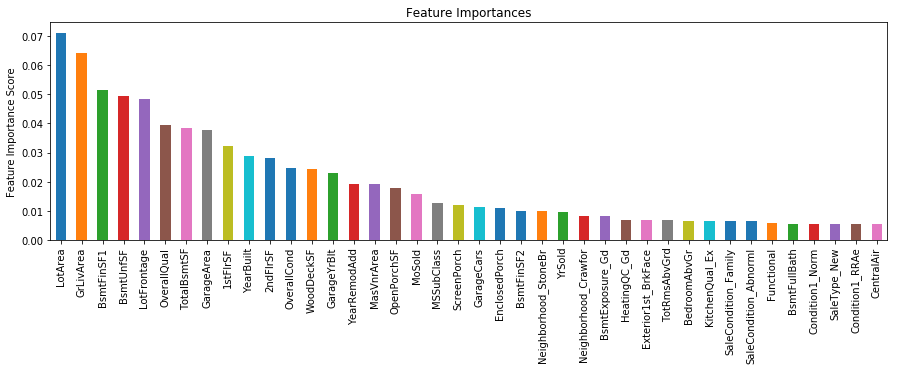

In [61]:
#Predict training set:
dtrain_predictions = xgb1.predict(train[predictors])
        
#Print model report:
print("\nModel Report" )
print("Mean Absolute Error : {:.2f}".format(metrics.mean_absolute_error(train[target].values, dtrain_predictions)))

feat_imp = pd.Series(xgb1.feature_importances_,predictors).sort_values(ascending=False)
feat_imp[0:40].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [52]:
metrics.mean_absolute_error(train[target].values, dtrain_predictions)

6594.072110445206

In [51]:
#metrics.accuracy_score(train[target].values, dtrain_predictions)
cross_val_score(xgb1,train[predictors],train[target],scoring = 'neg_mean_absolute_error')

array([-14488.09749583, -16135.32011197, -14838.57728909])

In [64]:
cross_val_score(xgb1,train[predictors],train[target],scoring = 'mean_absolute_error')

/home/perro/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/perro/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/perro/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


array([-14488.09749583, -16135.32011197, -14838.57728909])

In [28]:
var='Utilities'
print(pd.concat([data[var].value_counts().sort_values(ascending=False),#counts by category
           train[[var,'SalePrice']].groupby(var).mean().sort_values(var,ascending=False)],#price average by category
          axis=1))

        Utilities     SalePrice
AllPub       2916  180950.95682
NoSeWa          1  137500.00000


/home/perro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  after removing the cwd from sys.path.


In [12]:
data['Utilities'].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [13]:
train[['Utilities','SalePrice']].groupby('Utilities').mean()

,SalePrice
Utilities,
AllPub,180950.95682
NoSeWa,137500.00000


In [26]:
data['Street'].value_counts().sort_values(ascending=False)

Pave    2907
Grvl      12
Name: Street, dtype: int64

In [27]:
train[['Street','SalePrice']].groupby('Street').mean().sort_values(var,ascending=False)

,SalePrice
Street,
Pave,181130.538514
Grvl,130190.500000


In [16]:
var='Street'
pd.concat([data[var].value_counts(),#counts by category
           train[[var,'SalePrice']].groupby(var).mean()],#price average by category
          axis=1,sort=True)

,Street,SalePrice
Grvl,12,130190.500000
Pave,2907,181130.538514


In [18]:
train[['Street','SalePrice']].groupby('Street').mean()

,SalePrice
Street,
Grvl,130190.500000
Pave,181130.538514


In [23]:
pd.concat([data[var].value_counts(),#counts by category
           train[[var,'SalePrice']].groupby(var).mean()],#price average by category
          axis=1,sort=True).sort_values(var,ascending=False)

,Street,SalePrice
Pave,2907,181130.538514
Grvl,12,130190.500000
